In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


### now we need to define some variables
#these variablese will be used for each of the differential equations used to solve for changees
#in 
#Phytoplankton - 2 phytoplankton, 1 large and 1 small
#Zooplankton - 1 zooplankton
#DOC - 2 DOC, 1 non-photoreactive 1 photoreactive
#Detritus -2 detritus, 1 large and 1 small
#light absorption and backscattering, fully spectral to produce hyperspectral downwelling and upwelling irradiance
#


In [2]:
#first define the physical space and parameters of the location
Z=10 #depth in meters
X=1e3 # x width in meters
Y=1e3 #y width in meters
Q=0. #flow rate in m^3 s^-1 that will be forced into the model
mu_diff=1.e-6 # molecular diffusion rate
TurbDiff=0. #turbulence diffusion rate, will be calculated from surface mixing via wind velocity
Windvel=0. #wind velocity in m s^-1, will be read in from forcing
Temp=0. #temperature in C°  from forcing
Salt=0. #salinity from forcing

In [3]:
##now will initialize some chemical parameters that will be read in from forcing
NH4=0. #ammonium, from forcing in g m^-3
NO3=0. #nitrate, from forcing in g m^-3

#the below will be solved using differential equations but initializedd at a reasonable value for an estuary, all in g m^-3
DO2=10. #dissolved oxygeen concentration in g m^-3, dynamically calculated
NCDOC=1. #non-colored dissolved organic carbon, dynamically calculated
CDOC=1. #colored dissolved organic carbon, dynamically calculated
LPOC=1. #Labile particulate organic carbon, dynamically calculated
RPOC=1. #refractory particulate organic carbon, dynamically calculated

#now the biological variables
B1=0.05 #phytoplankton number 1 in g C m^-3
B2=0.05 #phytoplankton numbre 2 in g C m^-3
# Z1=0.01 #zooplankton in g C m^-3

PAR=0 # the integrated 400nm -700nm photosynthetically available radiation used for phytoplankton growth

In [4]:
#phytoplankton algae growth parameters related to nutrient uptake and growth
#now am going to define the parameters associated with each reaction that remain static through the model run and make some plots to show what they actually do


#algal basal metabolic coefficient, same for both
ktb1=0.032
ktb2=0.032

#reference temperature for algal metabolism
Tb1=20.
Tb2=20.

#algal predation temperature coefficient
ktpr1=0.032
ktpr2=0.032
#reference temperature for algal predation
Tpr1=20.
Tpr2=20.

#maximum photosynthetic rate for algae 1 and algae 2 (g C g chla^-1 d^-1)
PM1=300;
PM2=350;

#temperature scaled maximum photosynthetic rate, calculated
PP1=0.
PP2=0.

#basal metabolic rate for algae 1 and 2
BMR1=0.01
BMR2=0.02

#temperature scaled  metabolic rate for algae 1 and alge 2
BM1=0.
BM2=0


#basal algal predation rate from Kimmet et al. 2006 for zooplankton in CBay
BPR1=1.5
BPR2=1.5

#Predation rate of algae 1 and algae 2, calculated from temperature and algal concentration
PR1=0.
PR2=0.

# Nitrogen limitiation for algae 1 and 2, calculated from the relative concentrations of ammonium and nitrate
#preference for NH4 over NO3
PN1=0.
PN2=0.
#actual limitation function when combined with light scales the growth
NL1=0.
NL2=0.

#half saturation of inorganic nitrogen uptake by algae
khn1=0.025
khn2=0.025


#carbon to chla ratio g C g Chl^-1
cchla1=50.
cchla2=50.

#algal respiration coefficient
PRSP1=0.25
PRSP2=0.25

#algal sinking velocity
WS1=1.0
WS2=0.1

#algal temperature coefficients
kta1a=0.0018 #sub-optimal temperature coefficient for algae 1 production
kta1b=0.006 #super-optiamal temperature coefficient for algae 1 production
kta2a=0.0035 #sub-optimal temperature coefficient for algae 2 production
kta2b=0.000 #super-optiamal temperature coefficient for algae 2 production

#reference temperature for algal production
Tref1=16.0
Tref2=35.0;

In [5]:
#now just thrown a few plots up to demonstrate what each function actually does
Temp=np.linspace(1,35,100)
#temperature control for algae growth
thetaA1=np.linspace(1,1,100)
thetaA2=np.linspace(1,1,100)
#temperature control for algal metabolism
thetaB1=np.linspace(1,1,100)
thetaB2=np.linspace(1,1,100)
#temperature control for algal predation
thetaPR1=np.linspace(1,1,100)
thetaPR2=np.linspace(1,1,100)

# print(Temp)
# print(thetaA1)
# print(thetaA2)


In [6]:
#Function for phytoplankton growth response to temperature
def get_ft(kt1,kt2,Tref,T):
    #kt1 is the functional growth factor for suboptimal temperature, Tref<T
    #kt2 is the functional growth factor for superoptimal temperature, Tref<T
    #creates a bell-shaped curved
    if T<Tref: 
         theta=np.exp((-kt1*(T-Tref)**2))
    else:
         theta=np.exp((-kt2*(Tref-T)**2))
    return theta
# B1_theta=Tsub(kta1a,kta1b,Tref1,Temp)


In [7]:
#function for temperature response of algal metabolism
def get_ftbm(ktb,T,Tb):
    #ktb is the basal metabolic rate
    #T is the water temperature
    #Tb is the reference temperature for algal metabolism
    theta_B=np.exp(ktb*(T-Tb))
    return theta_B

#function for temperature response of algal predation
def get_ftpr(ktpr,T,Tpr):
    #ktb is the basal metabolic rate
    #T is the water temperature
    #Tb is the reference temperature for algal metabolism
    theta_PR=np.exp(ktpr*(T-Tpr))
    return theta_PR

In [8]:

for i in range(len(Temp)):
    #call the temperature 
    thetaA1[i]=get_ft(kta1a,kta1b,Tref1,Temp[i])
    thetaA2[i]=get_ft(kta2a,kta2b,Tref2,Temp[i])
    thetaB1[i]=get_ftbm(ktb1,Temp[i],Tb1)
    thetaB2[i]=get_ftbm(ktb2,Temp[i],Tb2)
    thetaPR1[i]=get_ftpr(ktpr1,Temp[i],Tpr1)
    thetaPR2[i]=get_ftpr(ktpr2,Temp[i],Tpr2)    
# #     print('Temp = ',Temp[i])
# #     print('kta1a = ',kta1a)
# #     print('kta1b = ',kta1b)
# #     print('Tref1 =', Tref1)

#code below works and gives correct answer, now need to make it work as a function
#     if Temp[i]<Tref1: 
#          thetaA1[i]=np.exp(-kta1a*(Temp[i]-Tref1)**2)
#     else:
#          thetaA1[i]=np.exp(-kta1b*(Tref1-Temp[i])**2)
#     if Temp[i]<Tref2: 
#          thetaA2[i]=np.exp(-kta2a*(Temp[i]-Tref2)**2)
#     else:
#          thetaA2[i]=np.exp(-kta2b*(Tref2-Temp[i])**2)  

# #     print(thetaA1[i])
# #     print(thetaA2[i])

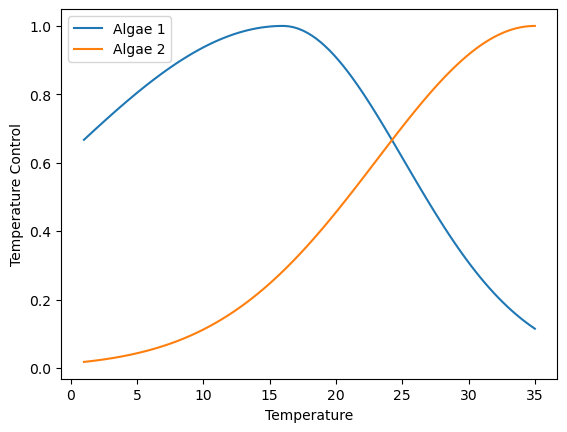

In [9]:
l1,=plt.plot(Temp,thetaA1)
l2,=plt.plot(Temp,thetaA2)
plt.ylabel('Temperature Control')
plt.xlabel('Temperature')
plt.legend([l1,l2],['Algae 1','Algae 2'])
plt.show()


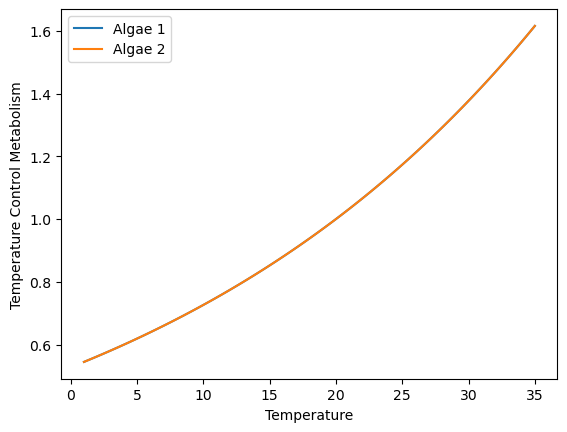

In [12]:
l1,=plt.plot(Temp,thetaB1)
l2,=plt.plot(Temp,thetaB2)
plt.ylabel('Temperature Control Metabolism')
plt.xlabel('Temperature')
plt.legend([l1,l2],['Algae 1','Algae 2'])
plt.show()

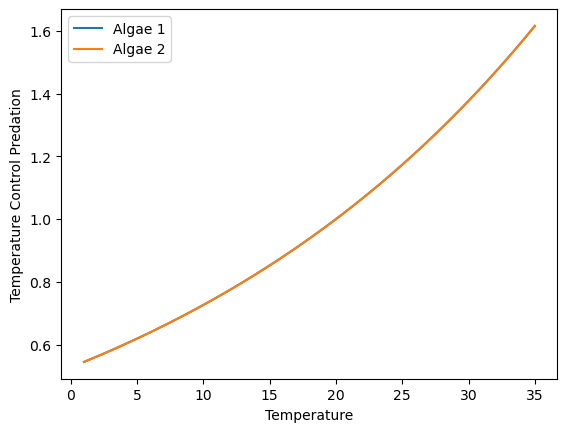

In [13]:
l1,=plt.plot(Temp,thetaPR1)
l2,=plt.plot(Temp,thetaPR2)
plt.ylabel('Temperature Control Predation')
plt.xlabel('Temperature')
plt.legend([l1,l2],['Algae 1','Algae 2'])
plt.show()

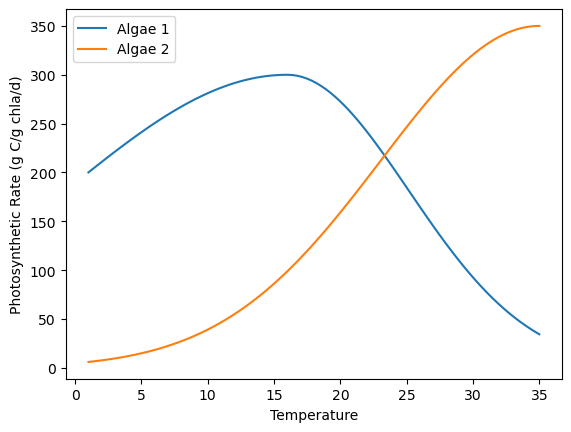

In [10]:
#Temperature scaled rates of primary production and metabolism of phytoplankton
PP1=PM1*thetaA1;
PP2=PM2*thetaA2;
BM1=BMR1*thetaB1;
BM2=BMR2*thetaB2;

l1, plt.plot(Temp,PP1)
l2, plt.plot(Temp,PP2)
plt.xlabel('Temperature')
plt.ylabel('Photosynthetic Rate (g C/g chla/d)')
plt.legend([l1,l2],['Algae 1','Algae 2'])
plt.show()

In [11]:
#functions for nitrogen limitation of phytoplankton from ICM
#can think about altering or simplifying 

#first the preference function for NH4 over NO4
    #NH4 is ammonium concentration, NO3 is nitrate concentration, 
    #khna is half saturation for Nitrogen limitation
def alg_PN(NH4,NO3,khna):
    leftside=NO3/((khna+NH4)*(khna+NO3));
    rightside=khna/((NH4+NO3)*(khna+NO3))
    
    PNa=NH4*(leftside+rightside)
    return PNa
    #now the function for total nitrogen limitation
def alg_NL(NH4,NO3,khna,PNa):
    topside=2*NH4+NO3-PNa*(NO3+NH4)
    bottomside=khna+2*NH4+NO3-PNa*(NO3+NH4)
    
    NLa=topside/bottomside
    return NLa

In [12]:
NH4=np.linspace(0.01,0.5,100)
NO3=np.linspace(0.01,1.0,100)
NL1=np.linspace(1,1,100)
NL2=np.linspace(1,1,100)

for i in range(len(NH4)):
    PN1=alg_PN(NH4[i],NO3[i],khn1)
    PN2=alg_PN(NH4[i],NO3[i],khn2)
    
    NL1[i]=alg_NL(NH4[i],NO3[i],khn1,PN1)
    NL2[i]=alg_NL(NH4[i],NO3[i],khn2,PN2)
    

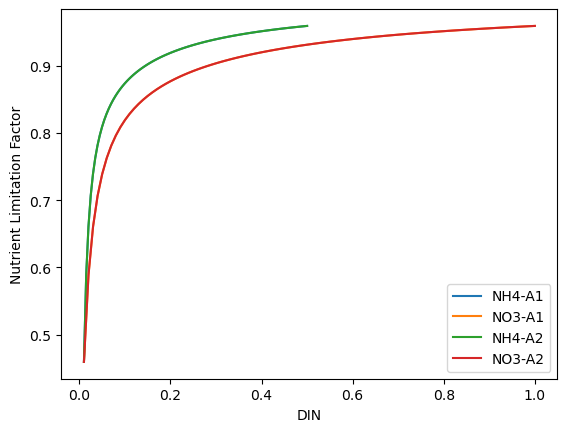

In [13]:
l1,=plt.plot(NH4,NL1)
l2,=plt.plot(NO3,NL1)
l3,=plt.plot(NH4,NL2)
l4,=plt.plot(NO3,NL2)
plt.xlabel('DIN');
plt.ylabel('Nutrient Limitation Factor')
plt.legend([l1,l2, l3, l4],['NH4-A1','NO3-A1','NH4-A2','NO3-A2'])
plt.show()

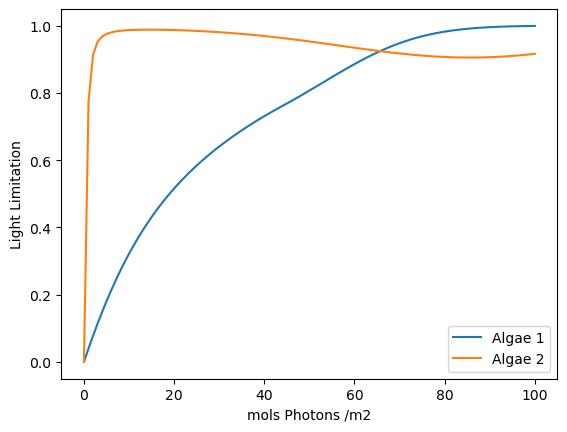

In [14]:
#now will go into the light limitation functions
#slope of Pvs I curve
alpha1=8
alpha2=8.
#set up a curve of PAR for phytoplankton growth, in mols Photons m^-2
PAR=np.linspace(0,100,100);
#light limitation functions
FI1=np.linspace(1,1,100)
FI2=np.linspace(1,1,100)
#light limitation function
IK1=np.linspace(1,1,100)#ratio of temperature scaled maximal primary production rate to C:chl ratio
IK2=np.linspace(1,1,100)#ratio of temperature scaled maximal primary production rate to C:chl ratio



for i in range(len(PAR)):
    IK1[i]=PP1[i]/alpha1;
    IK2[i]=PP2[i]/alpha2;
    
    FI1[i]=PAR[i]/(np.sqrt(IK1[i]**2+PAR[i]**2))
    FI2[i]=PAR[i]/(np.sqrt(IK2[i]**2+PAR[i]**2))

l1,=plt.plot(PAR,FI1)
l2,=plt.plot(PAR,FI2)
plt.legend([l1,l2],['Algae 1','Algae 2'])
plt.xlabel('mols Photons /m2')
plt.ylabel('Light Limitation')
plt.show()

In [20]:
#now that we have the nitrogen limitation and light limitation functions built out,
#we can now estimate primary production
#growth rate (in days) of algae 1 and 2
s=(100,100)
P1=np.zeros(s);
P2=np.zeros(s);
# print(P1)
# print(P2)
#algae 1 and 2 concentration, in Carbon
B1=np.linspace(1,1,100)
B2=np.linspace(1,1,100)

#now will create an array of nutrient vs light limitation and the effects on the growth
#rate of phytoplankton
for i in range(len(FI1)):
    for j in range(len(NL1)):

        P1[i,j]=PP1[i]*np.fmin(FI1[i],NL1[j])/cchla1
        P2[i,j]=PP2[i]*np.fmin(FI2[i],NL2[j])/cchla2


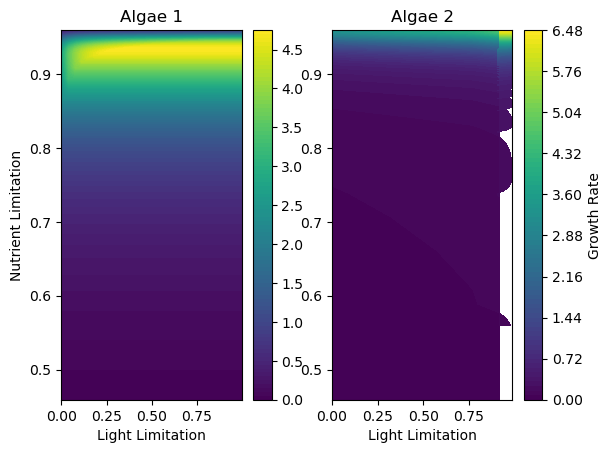

In [22]:
plt.subplot(1,2,1)
plt.contourf(FI1,NL1,P1,100)
plt.xlabel('Light Limitation')
plt.ylabel('Nutrient Limitation')
plt.title('Algae 1')
c=plt.colorbar()
# c.set_label('Growth Rate')

plt.subplot(1,2,2)
plt.contourf(FI2,NL2,P2,100)
plt.xlabel('Light Limitation')
# plt.ylabel('Nutrient Limitation')
plt.title('Algae 2')
c=plt.colorbar()
c.set_label('Growth Rate')
plt.show()

In [44]:
#but we have three limiting factors on the growth rate, nutrients and light
#as displayed above, but what about temperature??

In [23]:
#now calculate net primary production
NetPP1=np.zeros(s)
NetPP2=np.zeros(s)
#algal biomass, just make them a scalar for now
B1=np.linspace(0.1,3,100)
B2=np.linspace(0.1,2,100)
for i in range(len(BM1)):
    for j in range(len(B1)):
        NetPP1[i,j]=(P1[i,j]*(1-PRSP1)-BM1[i])*B1[j]
        NetPP2[i,j]=(P2[i,j]*(1-PRSP2)-BM2[i])*B2[j]
        

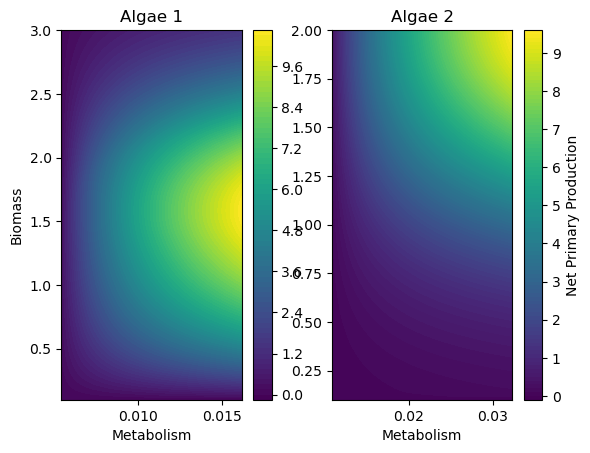

In [24]:
plt.subplot(1,2,1)
plt.contourf(BM1,B1,NetPP1,100)
plt.xlabel('Metabolism')
plt.ylabel('Biomass')
plt.title('Algae 1')
c=plt.colorbar()
# c.set_label('Growth Rate')

plt.subplot(1,2,2)
plt.contourf(BM2,B2,NetPP2,100)
plt.xlabel('Metabolism')
# plt.ylabel('Nutrient Limitation')
plt.title('Algae 2')
c=plt.colorbar()
c.set_label('Net Primary Production')
plt.show()

In [47]:
x = "awesome"

def myfunc():
  x = "fantastic"
  print("Python is " + x)

myfunc()

print("Python is " + x)

Python is fantastic
Python is awesome
